# Instructions
<strong>DRILL: Improve this gradient boost model</strong>

While this model is already doing all right (about 0.75 accuracy), we've seen from the Type I and Type II error rates that there is definitely room for improvement. Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set. Strategies you might use include:

- Creating new features
- Applying more overfitting-prevention strategies like subsampling
- More iterations
- Trying a different loss function
- Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Load and clean

In [3]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")
print(raw_df.shape)
raw_df.head()

(8594, 13)


,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


Let's check our nulls and our country counts:

In [269]:
raw_df.isnull().sum()

cntry        0
idno         0
year         0
tvtot        8
ppltrst     14
pplfair     39
pplhlp      25
happy       31
sclmeet     15
sclact      94
gndr        10
agea       239
partner     17
dtype: int64

In [270]:
raw_df.cntry.value_counts()

ES    2426
SE    1816
CH    1546
NO    1462
CZ    1316
DE      28
Name: cntry, dtype: int64

In [4]:
# Nulls: Dropping a couple hundred out of 8600 rows is no biggie.  
# Let's drop those - and the unnecessary ID number and year columns, while we're at it.
happiness_df = raw_df.dropna().copy()
happiness_df.drop(['idno', 'year'], axis=1, inplace=True)

# And let's convert partner to a Boolean rather than 1 or 2.
happiness_df['partner'] = happiness_df['partner']==1.0

# Because we've got just 28 people from Germany (compared to at least 1200 from every other country here) 
# let's drop Germany.
happiness_df = happiness_df[happiness_df['cntry']!='DE']

# Let's make gender a -1 / +1 binary (useful for multiplying columns for feature generation later):
happiness_df['gndr'] = (happiness_df['gndr']*2 - 3).astype(int)

# And we'll convert our countries into dummy variables later, when we do our train/test splits.
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,True
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,True
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,False
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,True
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,True


# Preliminary RF and boosted RT models

In [5]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(happiness_df.drop('partner', axis=1), columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [6]:
from sklearn.metrics import confusion_matrix
def show_conf_mat(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(5,5))
    conf_mat = np.round(confusion_matrix(y_test, y_pred)/len(y_test), 2)
    sns.heatmap(conf_mat, square=True, annot=True, annot_kws={'size':16}, cmap='RdBu_r', center=0, fmt='g')
    plt.title('confusion matrix (by percentage)')
    plt.show()

First, a basic random forest, aka random tree + bagging:

[0.73264402 0.70492611 0.69310345 0.72252341] 
 mean:  0.7132992462306431


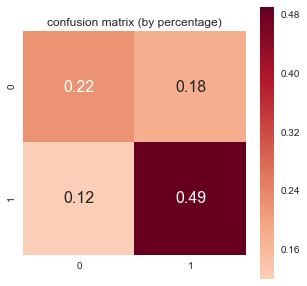

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier()
cv_score = cross_val_score(rfc, X, y, cv=4)
print(cv_score, '\n mean: ', np.mean(cv_score))

show_conf_mat(rfc)

Not bad.  And now for a basic RT + boosting model:

CV scores: [0.76415559 0.73990148 0.75123153 0.7555446 ] 
 mean:  0.7527082991397627
Train score:  0.784072249589491
Test score:  0.7433497536945812


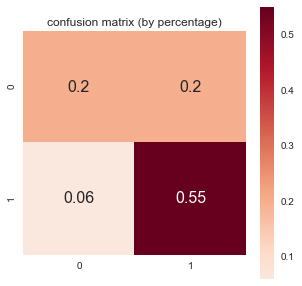

In [8]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}
# set random state!

gbc_1 = ensemble.GradientBoostingClassifier(**params)
cv_score = cross_val_score(gbc_1, X, y, cv=4)
gbc_1.fit(X_train, y_train)
train_score = gbc_1.score(X_train, y_train)
test_score = gbc_1.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

show_conf_mat(gbc_1)

About the same.  If we tinker with the parameters a bit (I've omitted the tinkering for sake of space), we see that we tend to overfit if we increase the depth of the trees.  Doubling or quadrupling the number of trees/estimators also leads to overfitting (albeit not as severe) with no true accuracy improvement.  Let's what a basic hyperparamter search turns up:

In [105]:
from sklearn.model_selection import RandomizedSearchCV
from time import time
param_dist = {
    'loss': ['deviance','exponential'],
    'n_estimators': [300,500,1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2,4,6,8],
    'max_features': [2,4,6,8],
    'subsample': [0.1, 0.3, 0.6, 1]
}

random_search = RandomizedSearchCV(gbc_1, param_distributions=param_dist,
                                   n_iter=30)
start = time()
random_search.fit(X_train, y_train)
print("Elapsed seconds: ", time()-start)

Elapsed seconds:  398.8521947860718


In [106]:
# report utility function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.753 (std: 0.003)
Parameters: {'subsample': 1, 'n_estimators': 500, 'max_features': 4, 'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: 0.752 (std: 0.005)
Parameters: {'subsample': 0.1, 'n_estimators': 500, 'max_features': 8, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.01}

Model with rank: 3
Mean validation score: 0.749 (std: 0.003)
Parameters: {'subsample': 0.1, 'n_estimators': 1000, 'max_features': 8, 'max_depth': 2, 'loss': 'deviance', 'learning_rate': 0.01}



In short, it looks like toggling the parameters isn't making much difference here: we can get more or less overfitting (with little effect on accuracy), but our accuracy maxes out around 0.75.  Finally, a quick look at AdaBoost:

CV scores: [0.75824717 0.73596059 0.7364532  0.74420897] 
 mean:  0.7437174829804253
Train score:  0.755008210180624
Test score:  0.7453201970443349


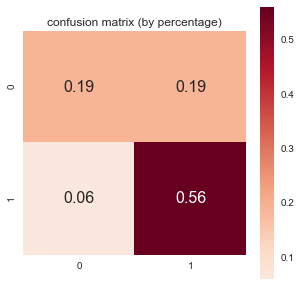

In [290]:
from sklearn.ensemble import AdaBoostClassifier

ada = ensemble.AdaBoostClassifier()
cv_score = cross_val_score(ada, X, y, cv=4)
ada.fit(X_train, y_train)
train_score = ada.score(X_train, y_train)
test_score = ada.score(X_test, y_test)

print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

show_conf_mat(ada)

Same results.  We're stuck at 0.75 accuracy no matter what we do with this data.  Let's try some feature engineering.

# Feature engineering

As an experiment here, I'm going to generate several new dataframes of featuresets to try running our models on.  The basic strategy will be:
- generate a bunch of relative, combinatoric, and/or polynomial features
- shrink featureset by selecting top feature_importances, and by running PCA
- test full datasets, top feature_importance datasets, and PCA datasets
- pick top performing dataset

The generated datasets are as follows:
- <b>happiness_df</b>: the original features
- <b>relative_df</b>: all of the original features scaled to the means of their respective countries
- <b>combo_df</b>: the original features plus all combinations of original features
- <b>combo_2_df</b>: the original features plus squared features plus all combinations
- <b>rel_combo_df</b>: the country-mean-scaled features plus all combinations of original features
- <b>rel_combo_2_df</b>: the country-mean-scaled features plus squared features plus all combinations

The PCA datasets will have to be generated separately post-train-test-split since PCA should only be fit to the training data.

In [64]:
# a little function to quickly construct boosted trees off a dataset and print the results
def test_data(df, has_cntry=True):
    start = time()
    if has_cntry:
        X = pd.get_dummies(df, columns=['cntry'])
    else:
        X = df
    y = happiness_df['partner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    params = {'n_estimators': 500,
              'max_depth': 2,
              'loss': 'deviance',
              'random_state': 12}

    gbc = ensemble.GradientBoostingClassifier(**params)
    # cv_score = cross_val_score(gbc, X, y, cv=4)
    gbc.fit(X_train, y_train)
    train_score = gbc.score(X_train, y_train)
    test_score = gbc.score(X_test, y_test)

    # print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
    print("Train score: ", train_score)
    print("Test score: ", test_score)
    print("Elapsed time (seconds): ", time()-start)

In [57]:
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,True
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,True
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,False
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,True
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,True


In [104]:
relative_df = happiness_df.copy()
for col_name in relative_df.columns[1:10]: # excludes country, partner
    cntry_means = relative_df.groupby('cntry')[col_name].agg(np.mean)
    cntry_means_col = [cntry_means[cntry] for cntry in relative_df['cntry']]
    relative_df[col_name] = relative_df[col_name] / cntry_means_col

In [91]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
combo_df = pd.DataFrame(poly.fit_transform(happiness_df.drop(['cntry', 'partner'], axis=1)))
combo_df['cntry'] = happiness_df['cntry'].copy()

In [42]:
poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=False)
combo_2_df = pd.DataFrame(poly.fit_transform(happiness_df.drop(['cntry', 'partner'], axis=1)))
combo_2_df['cntry'] = happiness_df['cntry'].copy()

In [43]:
poly = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
rel_combo_df = pd.DataFrame(poly.fit_transform(relative_df.drop(['cntry', 'partner'], axis=1)))
rel_combo_df['cntry'] = happiness_df['cntry'].copy()

In [45]:
poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
rel_combo_2_df = pd.DataFrame(poly.fit_transform(relative_df.drop(['cntry', 'partner'], axis=1)))
rel_combo_2_df['cntry'] = happiness_df['cntry'].copy()

In [67]:
print("*********\n Unmodified data: ")
test_data(happiness_df.drop('partner', axis=1))
print("*********\n Relative data: ")
test_data(relative_df.drop('partner', axis=1))
print("*********\n Feature-combined data: ")
test_data(combo_df)
print("*********\n Feature-combined + squared data: ")
test_data(combo_2_df)
print("*********\n Relative feature-combined data: ")
test_data(rel_combo_df)
print("*********\n Relative feature-combined + squared data: ")
test_data(rel_combo_2_df)
print("*********\n Relative feature-combined + squared data w/out country: ")
test_data(rel_combo_2_df.drop('cntry', axis=1), has_cntry=False)

*********
 Unmodified data: 
Train score:  0.7756978653530378
Test score:  0.7610837438423645
Elapsed time (seconds):  1.2638530731201172
*********
 Relative data: 
Train score:  0.7844006568144499
Test score:  0.761576354679803
Elapsed time (seconds):  1.5536901950836182
*********
 Feature-combined data: 
Train score:  0.8067323481116585
Test score:  0.7448275862068966
Elapsed time (seconds):  3.4626801013946533
*********
 Feature-combined + squared data: 
Train score:  0.80311986863711
Test score:  0.7517241379310344
Elapsed time (seconds):  3.8213019371032715
*********
 Relative feature-combined data: 
Train score:  0.8113300492610838
Test score:  0.7502463054187192
Elapsed time (seconds):  3.4512901306152344
*********
 Relative feature-combined + squared data: 
Train score:  0.8114942528735632
Test score:  0.7507389162561576
Elapsed time (seconds):  4.11787486076355
*********
 Relative feature-combined + squared data w/out country: 
Train score:  0.809688013136289
Test score:  0.74

Wow - we're still thoroughly stuck at the same level as the original, unmodified data.

Let's see if we can get some feature importance info here:

In [94]:
X = pd.get_dummies(rel_combo_2_df, columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'random_state': 12}

gbc_5 = ensemble.GradientBoostingClassifier(**params)
gbc_5.fit(X_train, y_train)
train_score = gbc_5.score(X_train, y_train)
test_score = gbc_5.score(X_test, y_test)

print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.8105090311986863
Test score:  0.7443349753694581


In [99]:
list(zip(X_train.columns, gbc_5.feature_importances_))

[(0, 0.002658168451719321),
 (1, 0.006874700794363099),
 (2, 0.0031254554698674207),
 (3, 0.0042357428978088175),
 (4, 0.011160549478467573),
 (5, 0.005970827282780144),
 (6, 0.00562920234325264),
 (7, 0.0013822186649489758),
 (8, 0.030111927644223446),
 (9, 0.004584941330842208),
 (10, 0.02150382394617033),
 (11, 0.023075475017970283),
 (12, 0.017500587603850926),
 (13, 0.03750135889897719),
 (14, 0.021198337752778178),
 (15, 0.03778854441583712),
 (16, 0.005029720919645038),
 (17, 0.04473047929002337),
 (18, 0.005937670649154597),
 (19, 0.021255877644401934),
 (20, 0.01940512322694452),
 (21, 0.012098131727546532),
 (22, 0.016872420384019045),
 (23, 0.03260374518907697),
 (24, 0.010288347098542738),
 (25, 0.03205925844699584),
 (26, 0.0004410700398778506),
 (27, 0.019721658942404807),
 (28, 0.02199584951310931),
 (29, 0.00815585567056927),
 (30, 0.007482558116451943),
 (31, 0.005342307350872606),
 (32, 0.024481054597291975),
 (33, 0.004780388154420795),
 (34, 0.01694476692147439),
 (

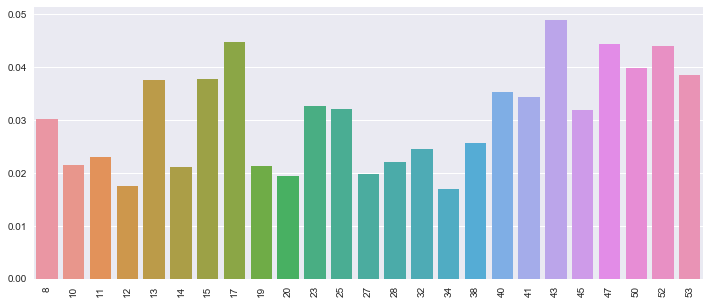

In [102]:
labeled_fi = sorted( list(zip(X_train.columns, gbc_5.feature_importances_)), key=lambda x: -x[1])
plt.figure(figsize=(12,5))
x_imp = [tup[0] for tup in labeled_fi[:25]]
y_labels = [tup[1] for tup in labeled_fi[:25]]
plt.xticks(rotation=90)
sns.barplot(x_imp, y_labels);

Bafflingly, this isn't graphing as sorted, even though it in fact sorted (see below).  ????  At any rate, it's of no interpretational use because the labels produced by sklearn's combination algorithm are totally uninformative. We could try taking the top 10 features and hoping those produce something better than PCA (already run below, and still stuck at 0.75).  But that seems very doubtful, and I'm about out of steam here.

In [103]:
sorted( list(zip(X_train.columns, gbc_5.feature_importances_)), key=lambda x: -x[1])[:10]

[(43, 0.04899211896818679),
 (17, 0.04473047929002337),
 (47, 0.04437088266776617),
 (52, 0.044065031299843474),
 (50, 0.03984730607745518),
 (53, 0.038456168028142106),
 (15, 0.03778854441583712),
 (13, 0.03750135889897719),
 (40, 0.035265157622594974),
 (41, 0.03432860636426225)]

PCA with regularized combination squared featureset:

In [85]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform ( pd.get_dummies(combo_2_df, columns=['cntry']) )
X_train, X_test, y_train, y_test = train_test_split(X, happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=20)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

In [86]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

gbc_pca = ensemble.GradientBoostingClassifier(**params)
# cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(Xpc_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

# print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.8057471264367816
Test score:  0.7300492610837438


PCA with unregularized combination squared featureset:

In [87]:
X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(combo_2_df, columns=['cntry']), happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=20)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

In [88]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

gbc_pca = ensemble.GradientBoostingClassifier(**params)
# cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(Xpc_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

# print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.8180623973727422
Test score:  0.7502463054187192


Oddly, this score is higher.

Finally, PCA with unregularized *relative* combo squared featureset:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(rel_combo_2_df, happiness_df['partner'], test_size=0.25)
pca = PCA(n_components=12)
pca.fit(X_train)
Xpc_train = pca.transform(X_train)
Xpc_test = pca.transform(X_test)

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

gbc_pca = ensemble.GradientBoostingClassifier(**params)
# cv_score = cross_val_score(gbc_pca, X, y, cv=4)
gbc_pca.fit(Xpc_train, y_train)
train_score = gbc_pca.score(Xpc_train, y_train)
test_score = gbc_pca.score(Xpc_test, y_test)

# print("CV scores:", cv_score, '\n mean: ', np.mean(cv_score))
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.783743842364532
Test score:  0.6970443349753694


# Conclusion:

A summary of what I've tried:
- a hyperparameter sweep of all the main parameters of Gradient Boost
- all possible two-variable combinations of the data
- squaring all variables in the data
- normalizing all data columns to the individual's country's averages
- running PCA on both regularized and unregularized versions of the maximal dataset.

All of these methods produced between 0.70 and 0.75 accuracy.  

Overall, I have just no idea how to use the data here to get better accuracy than 0.75.  It seems that nearly any form of random forest or boosted forest will get you at least 0.72, but no amount of feature engineering or algorithm tweaking will get you beyond 0.75.  It's possible, I suppose, that 24% of the "partner" variable is just noise unrelated to any of the data here, in which case we've hit the hard ceiling.  However, that would be exceptionally mean for Thinkful to do (since that's the initial accuracy they achieved and told us to improve on), so I'm hopeful that I'm missing something here.

One tentative conclusion here - which would be very useful to know, if true - is that random forests and gradient boosted trees already capture all inter-feature relationships, so adding combined features won't make any substantial difference.  They also aren't linearly constrained, so it's not totally clear that adding polynomial features will do much good either.  Which begs the question: is feature engineering theoretically irrelevant for these models?  (which would make it odd that Thinkful recommended we try it...)

Finally, the obvious quasi-cheat here (and the only way I can think of to improve on this) is to insert some relevant data about the countries - average marriage age, for instance - and see if that helps.  But presumably much of that effect should already be captured in the algorithm's treatment of the country column.

# One other question based on an early attempt here:

In [228]:
# for col_name in happiness_df.columns[1:10]: # excludes country, partner
#     cntry_means = happiness_df.groupby('cntry')[col_name].agg(np.mean)
#     happiness_df['relative_'+col_name] = happiness_df[col_name] / cntry_means[happiness_df['cntry']]
# FIXED THIS BELOW BY GENERATING A NEW LIST but it's odd that the indexing doesn't allow it - I don't know why.

# First, every score is probably more important relative to fellow citizens than to other EU countries
# (what makes us happy is sometimes not what we have, but what we have compared to the Joneses)
for col_name in happiness_df.columns[1:10]: # excludes country, partner
    cntry_means = happiness_df.groupby('cntry')[col_name].agg(np.mean)
    cntry_means_col = [cntry_means[cntry] for cntry in happiness_df['cntry']]
    happiness_df['relative_'+col_name] = happiness_df[col_name] / cntry_means_col

# tvtot may be different based on happiness, and based on social interactions
happy_scaled = (happiness_df['happy'] - np.mean(happiness_df.happy)) / 10
sclmeet_scaled = (happiness_df['sclmeet'] - np.mean(happiness_df.sclmeet)) / 10
happiness_df['tv_happ'] = happiness_df['tvtot'] * happy_scaled
happiness_df['tv_soc'] = happiness_df['tvtot'] * sclmeet_scaled

# age and happiness are likely to have a significant interaction - older singles are probably less likely
# to be happy single than people in their 20s
happiness_df['age_happ'] = (happiness_df['agea'] - np.mean(happiness_df.agea)) * happiness_df.happy

# finally, number of social activities interacting with gender and age may predict partner
# note: subtracting 1.5 from gndr makes it a binary -0.5 and 0.5
happiness_df['gender_sclact'] = (happiness_df['gndr'] * happiness_df['sclact']) 
# multiply 

# and finally, let's try correlating gender with all other features
happiness_df.head()

,cntry,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,...,relative_pplhlp,relative_happy,relative_sclmeet,relative_sclact,relative_gndr,relative_agea,tv_happ,tv_soc,age_happ,gender_sclact
0,CH,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1,60.0,...,0.879442,0.986045,0.970906,1.455712,44.69697,1.285683,0.087340,-0.065320,102.160591,4.0
1,CH,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1,59.0,...,0.879442,1.109301,0.582543,0.727856,44.69697,1.264255,0.774680,-1.330640,105.930665,2.0
2,CH,1.0,8.0,8.0,8.0,7.0,6.0,3.0,-1,24.0,...,1.407107,0.862789,1.165087,1.091784,-44.69697,0.514273,-0.070887,0.078227,-162.609483,-3.0
3,CH,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1,64.0,...,1.231219,1.232556,1.165087,0.727856,44.69697,1.371395,0.916453,0.312906,167.700739,2.0
4,CH,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1,55.0,...,0.879442,0.986045,1.359268,0.727856,44.69697,1.178543,0.145567,0.891133,62.160591,2.0


Now let's winnow them down using feature importance testing:

In [255]:
X = pd.get_dummies(happiness_df.drop('partner', axis=1), columns=['cntry'])
y = happiness_df['partner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Train score:  0.8853858784893268 
Test score:  0.7527093596059113


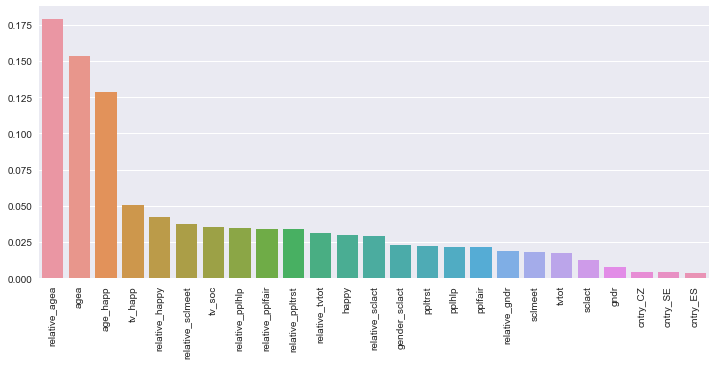

In [256]:
rfc_2 = RandomForestClassifier(n_estimators=100, max_depth=12)
rfc_2.fit(X_train, y_train)
train_score = rfc_2.score(X_train, y_train)
test_score = rfc_2.score(X_test, y_test)
print("Train score: ", train_score, "\nTest score: ", test_score)
labeled_fi = sorted( list(zip(X_train.columns, rfc_2.feature_importances_)), key=lambda x: -x[1])
plt.figure(figsize=(12,5))
x_imp = [tup[0] for tup in labeled_fi[:25]]
y_labels = [tup[1] for tup in labeled_fi[:25]]
plt.xticks(rotation=90)
sns.barplot(x_imp, y_labels);

On an initial look, it seems we've got more overfitting but no more accuracy.  What's surprising here to me is that there's no accuracy gain even though nine of the ten most important features are engineered features.  I would think that generating new features more predictively important than the old features would entail an accuracy gain.  Why doesn't it?